# Exploration

In [4]:
import time
import os
# os.environ["MKL_THREADING_LAYER"] = "GNU"
import keras
# import theano
import numpy as np
import pandas as pd
import decimal
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from scipy import stats

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

# print 'theano version:', theano.__version__
# print 'theano config device:', theano.config.device, theano.config.floatX
print('keras version:', keras.__version__)
print('pandas version:', pd.__version__)
print('numpy version:', np.__version__)

keras version: 2.2.4
pandas version: 0.23.0
numpy version: 1.14.3


In [5]:
test = pd.read_csv('test.csv')
train = pd.read_csv('training.csv')

test['Image'] = test.Image.apply(lambda im: np.fromstring(im, sep=' '))
train['Image'] = train.Image.apply(lambda im: np.fromstring(im, sep=' '))

In [6]:
train.iloc[:5,:5]

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x
0,66.033564,39.002274,30.227008,36.421678,59.582075
1,64.332936,34.970077,29.949277,33.448715,58.856170
2,65.057053,34.909642,30.903789,34.909642,59.412000
3,65.225739,37.261774,32.023096,37.261774,60.003339
4,66.725301,39.621261,32.244810,38.042032,58.565890


In [8]:
print(train.count())

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [9]:
train = train.dropna()
# train = train.sample(frac=1).reset_index(drop=True)
train_data = train.Image
train_labels = train[train.columns[:-1]]
train_data.shape, train_labels.shape

((2140,), (2140, 30))

In [10]:
idx = np.random.randint(0, len(train_data), 16)

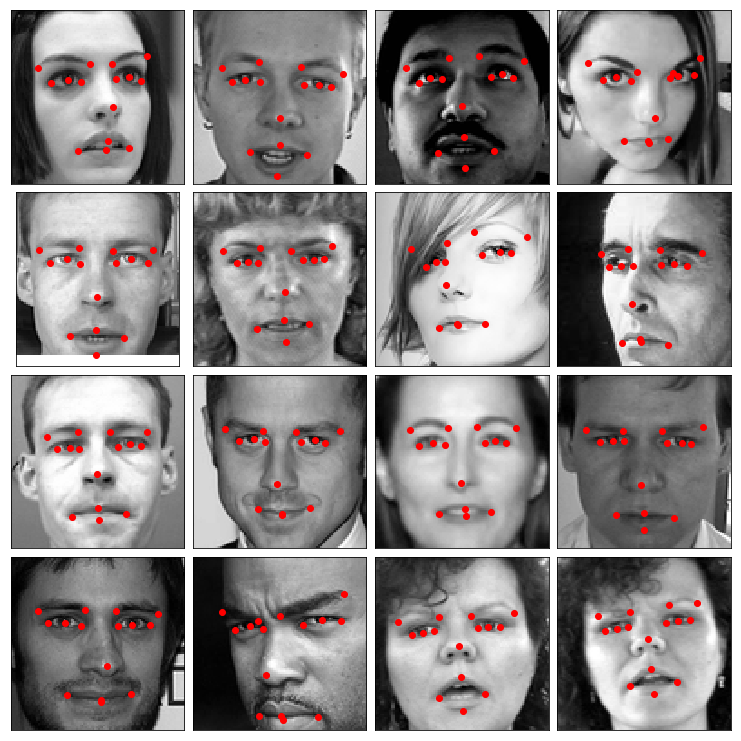

In [13]:
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i, loc in enumerate(idx):
    img = train_data.iloc[loc].reshape(96,96)
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(img, cmap='gray')
    for c in range(0, len(train_labels.columns)-1, 2):
        x = train_labels[train_labels.columns[c]].iloc[loc]
        y = train_labels[train_labels.columns[c+1]].iloc[loc]
        plt.scatter(x, y, c='r')

In [14]:
train_labels.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166


# Attempting (and Failing) to make a CNN

In [15]:
# from __future__ import print_function
# import keras
# # from keras.datasets import mnist
# from keras.layers import Dense, Flatten
# from keras.layers import Conv2D, MaxPooling2D
# from keras.models import Sequential
# import matplotlib.pylab as plt

In [47]:
batch_size = 128
num_classes = 30
epochs = 10

# input image dimensions
img_x, img_y = 96,96

In [48]:
x_train = train_data
x_train.shape

(2140,)

In [49]:
x_train = x_train.apply(lambda im: im.reshape(96,96))
x_train.shape

(2140,)

In [50]:
x_train[0].shape

(96, 96)

In [51]:
img_x, img_y = x_train[0].shape

In [52]:
test.head()

,ImageId,Image
0,1,"[182.0, 183.0, 182.0, 182.0, 180.0, 180.0, 176..."
1,2,"[76.0, 87.0, 81.0, 72.0, 65.0, 59.0, 64.0, 76...."
2,3,"[177.0, 176.0, 174.0, 170.0, 169.0, 169.0, 168..."
3,4,"[176.0, 174.0, 174.0, 175.0, 174.0, 174.0, 176..."
4,5,"[50.0, 47.0, 44.0, 101.0, 144.0, 149.0, 120.0,..."


In [53]:
x_test = test.Image.apply(lambda im: im.reshape(96,96))
x_test.shape

(1783,)

In [116]:
# reshape the data into a 4D tensor - (sample_number, x_img_size, y_img_size, num_channels)
# because the image is greyscale, we only have a single channel - RGB colour images would have 3
x_train = np.stack(x_train, axis=0)
x_test = np.stack(x_test, axis=0)
x_train = x_train.reshape(x_train.shape[0], img_x, img_y, 1)
x_test = x_test.reshape(x_test.shape[0], img_x, img_y, 1)
input_shape = (img_x, img_y, 1)
input_shape, x_train.shape, x_test.shape

((96, 96, 1), (2140, 96, 96, 1), (1783, 96, 96, 1))

In [56]:
# convert the data to the right type
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# x_train /= 255
# x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (2140, 96, 96, 1)
2140 train samples
1783 test samples


In [57]:
# # convert class vectors to binary class matrices - this is for use in the
# # categorical_crossentropy loss below
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)
# y_train.shape, y_test.shape

In [58]:
y_train = train_labels

In [62]:
y_train.shape

(2140, 30)

In [88]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [86]:
?model.compile

In [89]:
# model.compile(loss=keras.losses.categorical_crossentropy,
#               optimizer=keras.optimizers.Adam(),
#               metrics=['accuracy'])
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(
    loss='mean_squared_error',
    optimizer=sgd
)

In [90]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))

history = AccuracyHistory()

In [91]:
?model.fit

In [92]:
model.fit(x_train, y_train,
          batch_size=batch_size,
#           epochs=epochs,
          epochs=2,
          verbose=1,
#           validation_data=(x_test, y_test),
          callbacks=[history])
# score = model.evaluate(x_test, y_test, verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])
# plt.plot(range(1, 11), history.acc)
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.show()

Epoch 1/2
2140/2140 [==============================] - 67s 31ms/step - loss: 2613.6027
Epoch 2/2
2140/2140 [==============================] - 64s 30ms/step - loss: 2613.4060


In [93]:
pred = model.predict(x_test)

In [94]:
pred.shape

(1783, 30)

In [95]:
pred[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [70]:
idx = np.random.randint(0, len(x_test), 16)

In [73]:
x_test[0].reshape(96,96).shape

(96, 96)

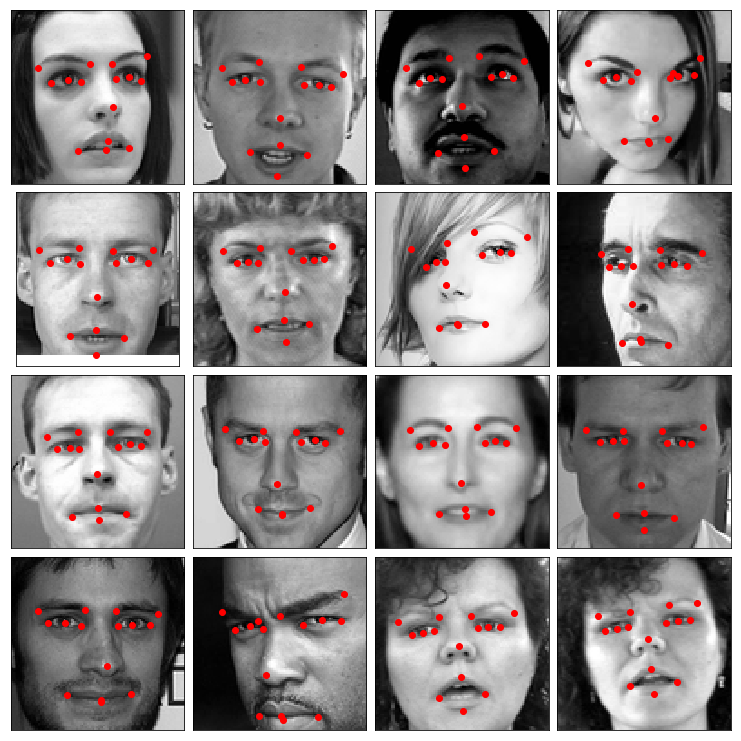

In [13]:
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i, loc in enumerate(idx):
    img = x_test.iloc[loc].reshape(96,96)
    ax = fig.add_subplot(4, 4, i + 1, axis='off')
    ax.imshow(img, cmap='gray')
    for c in range(0, len(pred.columns)-1, 2):
        x = train_labels[train_labels.columns[c]].iloc[loc]
        y = train_labels[train_labels.columns[c+1]].iloc[loc]
        plt.scatter(x, y, c='r')

# Recreate Daniel Nouri model in Keras

In [99]:
FTRAIN = 'training.csv'
FTEST = 'test.csv'

In [135]:
from sklearn.utils import shuffle

def load(test=False, cols=None):

    fname = FTEST if test else FTRAIN
    df = pd.read_csv(os.path.expanduser(fname))

    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:
        df = df[list(cols) + ['Image']]

#     print(df.count())
    df = df.dropna()

    X = np.vstack(df['Image'].values) / 255.
    X = X.astype(np.float32)

    if not test:
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48
        X, y = shuffle(X, y, random_state=42)
        y = y.astype(np.float32)
    else:
        y = None

    return X, y

In [108]:
x,y = load()
x.shape

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

(2140, 9216)

In [109]:
def load2d(test=False, cols=None):
    X, y = load(test, cols)
    X = X.reshape(-1, 1, 96, 96)
#     X = X.reshape(-1, 96, 96, 1)
    return X, y

In [136]:
X, y = load2d()

In [137]:
X.shape

(2140, 1, 96, 96)

In [140]:
model2 = Sequential()

# first group of layers
model2.add(Conv2D(
    32, 
    kernel_size=(3,3), 
    activation='relu',
    input_shape=(1, 96, 96), 
    data_format='channels_first'
))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# second group of layers
model2.add(Conv2D(
    64, 
    kernel_size=(2, 2), 
    activation='relu'
))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# third group of layers
model2.add(Conv2D(
    128, 
    kernel_size=(2, 2), 
    activation='relu'
))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())
model2.add(Dense(500, activation='relu'))
model2.add(Dense(500, activation='relu'))
model2.add(Dense(30))

sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model2.compile(loss='mean_squared_error', optimizer=sgd)
# hist2 = model2.fit(X, y, nb_epoch=1000, validation_split=0.2)

In [141]:
model2.fit(X, y,
          epochs=4,
          validation_split=0.2,
          callbacks=[history])

Train on 1712 samples, validate on 428 samples
Epoch 1/4
1712/1712 [==============================] - 64s 38ms/step - loss: 0.0273 - val_loss: 0.0078
Epoch 2/4
1712/1712 [==============================] - 62s 36ms/step - loss: 0.0072 - val_loss: 0.0061
Epoch 3/4
1712/1712 [==============================] - 63s 37ms/step - loss: 0.0058 - val_loss: 0.0053
Epoch 4/4
1712/1712 [==============================] - 63s 37ms/step - loss: 0.0051 - val_loss: 0.0048


In [150]:
np.sqrt(0.0048) * 48

3.3255375505322444

In [142]:
x_test, y_test = load2d(test=True)

In [144]:
pred = model2.predict(x_test)
pred[0]

array([ 0.37957075, -0.23191814, -0.38890368, -0.22942804,  0.22672912,
       -0.22009747,  0.51584625, -0.2196367 , -0.23807672, -0.21202885,
       -0.54999834, -0.1992589 ,  0.17052625, -0.38828486,  0.6348588 ,
       -0.39659896, -0.18223411, -0.39112663, -0.66667587, -0.35548127,
        0.00869236,  0.19637176,  0.31770653,  0.5619022 , -0.3083244 ,
        0.5976026 ,  0.00987129,  0.5074572 ,  0.02360651,  0.7169337 ],
      dtype=float32)

In [155]:
idx = np.random.randint(0, len(x_test), 16)

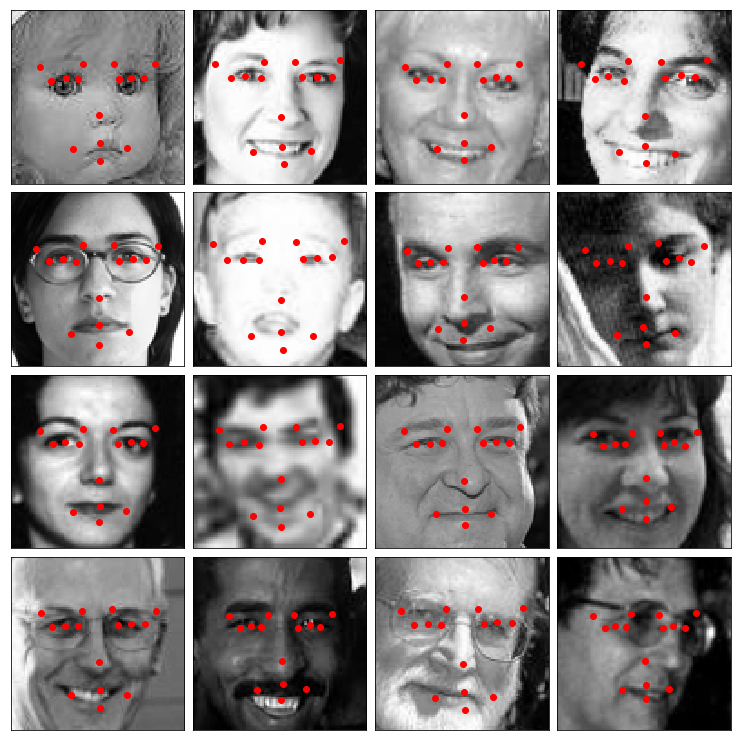

In [158]:
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(left=0, right=1, 
                    bottom=0, top=1, 
                    hspace=0.05, wspace=0.05)
for i, loc in enumerate(idx):
    img = x_test[loc].reshape(96,96)
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(x_test[loc].reshape(96,96), cmap='gray')
    ax.scatter(pred[loc][0::2] * 48 + 48, 
               pred[loc][1::2] * 48 + 48, c='r')